In [137]:
# Python 2 
from __future__ import division

# Dataframe
import pandas as pd
import numpy as np

# The Hashing Trick
from sklearn.feature_extraction import FeatureHasher

# ML
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import neighbors

# Scoring
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Visu
import matplotlib.pyplot as plt

# Dimension Reduction
from sklearn.decomposition import TruncatedSVD

In [51]:
stations = pd.read_csv('data/station.csv')

trips = pd.read_csv('data/trip_train.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)

weather = pd.read_csv('data/weather.csv', parse_dates=['date'], infer_datetime_format=True)

In [52]:
trips['start_time'] = trips.start_date.dt.hour
trips['start_date'] = pd.to_datetime(trips.start_date.dt.date)

In [53]:
trips.rename(columns = {'start_date':'date'}, inplace=True)

In [54]:
d = {'city': ['San Jose','Redwood City','Mountain View', 'Palo Alto', 'San Francisco'],\
         'zip_code':[95113,94063,94041,94301,94107]}
city_zip_codes = pd.DataFrame(data = d)

In [55]:
stations = pd.merge(stations, city_zip_codes, on='city', how='left')
stations

,id,name,lat,long,dock_count,city,installation_date,zip_code
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,95113
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,95113
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013,95113
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013,95113
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013,95113
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013,95113
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013,95113


In [56]:
# se agrega el zip_code de la ciudad de la start station a cada viaje
stations_to_join = stations.loc[:,['id','zip_code']]
stations_to_join.columns = ['start_station_id','city_zip_code']

trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

In [57]:
# # se agrega el zip_code de la ciudad de la start station a cada viaje
# stations_to_join = stations.loc[:,['id','zip_code', 'lat', 'long']]
# stations_to_join.columns = ['start_station_id','city_zip_code', 'start_lat', 'start_long']

# trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

# # se agrega el zip_code de la ciudad de la start station a cada viaje
# stations_to_join = stations.loc[:,['id', 'lat', 'long']]
# stations_to_join.columns = ['end_station_id', 'end_lat', 'end_long']

# trips = pd.merge(trips, stations_to_join, on='end_station_id', how='left')

# trips.dtypes

# from math import sqrt

# new_column = []                    #empty column for distance
# for index,row in trips.iterrows():
#     lat1 = row['start_lat'] #first row of location.lat column here
#     lon1 = row['start_long'] #first row of location.long column here
#     lat2 = row['end_lat'] #second row of location.lat column here
#     lon2 = row['end_long'] #second row of location.long column here
#     value = sqrt((lat2-lat1)**2 + (lon2-lon1)**2)  #get the distance
#     new_column += [value]   #append the empty list with distance values

# trips['distance'] = pd.Series(new_column)
# trips

# plt.figure(figsize=(15,8))
# plt.ylim(ymax=100000)
# plt.scatter(x=trips['distance'],y=trips['duration'])
# plt.show()

In [58]:
weather.rename(columns={'zip_code':'city_zip_code'}, inplace=True)

In [59]:
data = pd.merge(trips, weather, on=['date','city_zip_code'], how='inner')

In [60]:
data.columns

Index([u'id', u'duration', u'date', u'start_station_name', u'start_station_id',
       u'end_date', u'end_station_name', u'end_station_id', u'bike_id',
       u'subscription_type', u'zip_code', u'start_time', u'city_zip_code',
       u'max_temperature_f', u'mean_temperature_f', u'min_temperature_f',
       u'max_dew_point_f', u'mean_dew_point_f', u'min_dew_point_f',
       u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'precipitation_inches', u'cloud_cover', u'events',
       u'wind_dir_degrees'],
      dtype='object')

In [61]:
data['start_day'] = data['date'].dt.dayofweek
data['end_day'] = data['end_date'].dt.dayofweek
data['end_time'] = data['end_date'].dt.hour
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [62]:
data.drop(labels=['id','start_station_name','end_station_name','precipitation_inches','date','end_date','zip_code','bike_id'], axis=1, inplace=True)
data.columns

Index([u'duration', u'start_station_id', u'end_station_id',
       u'subscription_type', u'start_time', u'city_zip_code',
       u'max_temperature_f', u'mean_temperature_f', u'min_temperature_f',
       u'max_dew_point_f', u'mean_dew_point_f', u'min_dew_point_f',
       u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'cloud_cover', u'events', u'wind_dir_degrees', u'start_day',
       u'end_day', u'end_time', u'month', u'year'],
      dtype='object')

In [63]:
data

,duration,start_station_id,end_station_id,subscription_type,start_time,city_zip_code,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,mean_wind_speed_mph,max_gust_speed_mph,cloud_cover,events,wind_dir_degrees,start_day,end_day,end_time,month,year
0,396,50,60,Subscriber,8,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,8,8,2015
1,486,54,48,Subscriber,12,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,12,8,2015
2,1027,69,77,Subscriber,8,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,8,8,2015
3,354,77,62,Subscriber,8,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,8,8,2015
4,209,69,65,Subscriber,15,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,15,8,2015
5,849,69,41,Subscriber,8,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,8,8,2015
6,981,50,82,Subscriber,9,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,10,8,2015
7,239,55,41,Subscriber,13,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,14,8,2015
8,698,51,70,Customer,20,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,20,8,2015
9,414,76,70,Subscriber,17,94107,84.0,72.0,59.0,58.0,...,6.0,29.0,2.0,NaN,272.0,3,3,17,8,2015


# The Hashing Trick

In [64]:
temp = []
column_labels = ['start_station_id','end_station_id','subscription_type','city_zip_code','events']

for row in data.loc[:,column_labels].iterrows():
    index, value = row
    for i in range(len(value)):
        value[i] = str(value[i])
    temp.append(value.tolist())

In [65]:
h = FeatureHasher(n_features=10, input_type='string')
f = h.transform(raw_X=temp)

In [66]:
f.nnz/ (f.shape[0] * f.shape[1])

0.4119112082493122

In [67]:
pd.DataFrame(f.todense())

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-3.0
2,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-1.0
3,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-2.0
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,1.0,-1.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-1.0
8,0.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,-1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0


In [68]:
data = pd.concat([data,pd.DataFrame(f.todense())],axis=1)
data.drop(labels=column_labels,axis=1,inplace=True)

In [69]:
data.dtypes

duration                            int64
start_time                          int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
cloud_cover                       float64
wind_dir_degrees                  float64
start_day                           int64
end_day                           

In [70]:
data = data.dropna(how='any').reset_index(drop=True)
data.shape

(533260, 37)

In [71]:
target_values = data['duration']
data.drop(labels='duration', axis=1, inplace=True)

# Data normalization

In [72]:
data = (data - data.mean()) / (data.max() - data.min())

# Dimension Reduction

In [103]:
data.shape

(533260, 36)

In [101]:
u,s,v = np.linalg.svd(data.as_matrix(),full_matrices=0)

# Aproximation error

In [127]:
dim = 5
closeness = np.isclose(np.dot(np.dot(u[:,0:dim],np.diag(s)[0:dim,0:dim]),v[0:dim,:]),data,atol=0.1,rtol=0.1)
print closeness.sum()/(closeness.shape[0]*closeness.shape[1])

0.853638000225


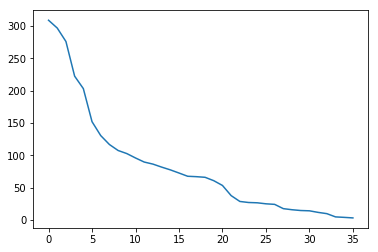

In [74]:
%matplotlib inline
#plt.xlim(xmax=15)
plt.plot(s)

# Truncated svd 

In [144]:
svd = TruncatedSVD(n_components=7, n_iter=7, random_state=42)
u_2 = svd.fit_transform(data)

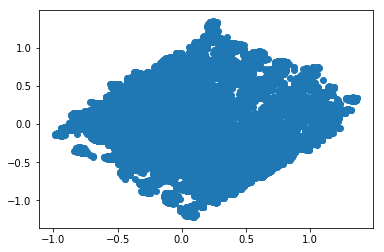

In [143]:
plt.scatter(x=u_2[:,0],y=u_2[:,1])

# TSNE

In [145]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
#np.set_printoptions(suppress=True)
model.fit_transform(u_2)

MemoryError: 

# KNN 

In [75]:
reduced_data = u[:,0:5]

In [76]:
reduced_data

array([[ 0.00017421, -0.00043008, -0.00043144, -0.00257028, -0.00170873],
       [ 0.00019442, -0.00043616, -0.000419  , -0.00263958, -0.00050439],
       [ 0.00018369, -0.00041836, -0.00044778, -0.00266233, -0.00169743],
       ..., 
       [ 0.00143074, -0.0010586 , -0.00158653,  0.00064973, -0.00136722],
       [ 0.0014216 , -0.00105558, -0.0015873 ,  0.00065794, -0.00166888],
       [ 0.00202899, -0.00115055,  0.00068658, -0.00177878,  0.00154013]])

In [84]:
k_neighbors = [2, 3, 10, 100]
metrics = ['euclidean', 'manhattan']
cv_scores = np.zeros(shape=(len(k_neighbors),len(metrics)))

for i,k in enumerate(k_neighbors):
    for j,metric in enumerate(metrics):
        
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric=metric, weights = 'distance')
        scores = cross_val_score(knn, reduced_data, target_values, cv=10, scoring='neg_mean_squared_error')
        cv_scores[i][j] = scores.mean()

In [88]:
print cv_scores

[[ -3.49466117e+09  -2.97760909e+09]
 [ -2.55739473e+09  -2.04934071e+09]
 [ -9.49209956e+08  -9.05045820e+08]
 [ -6.16463342e+08  -6.14878799e+08]]


In [ ]:
# finding best hyperparameters for knn with grid search and cross-validation

possible_k = [2, 3, 10, 100]
possible_metric = ['euclidean', 'manhattan']
number_of_splits = 5
kf = KFold(n_splits=number_of_splits)
min_error = float('inf')
best_k = 0
best_metric = ''

for k in possible_k:
    for metric in possible_metric:

        error = 0
        
        for train,test in kf.split(reduced_data):
            train_set_x = reduced_data[train]  # los train_set son para hacer el fit con el knn
            train_set_y = target_values[train]

            test_set_x = reduced_data[test]  # los test_set_x son los que seran predecidos
            test_set_y = target_values[test]  # los test_set_y son los valores de duracion que deberian dar como resultado

            knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric=metric, weights = 'distance')
            knn.fit(train_set_x, train_set_y)

            m = train_set_x.shape[0] # number of observations
            
            pred = knn.predict(test_set_x)
            
#             print pred.shape, test_set_y.as_matrix().shape
#             for i, val in enumerate(pred):
#                 print val, test_set_y[i]
            print(test_set_y.as_matrix()[:2], pred[:2], mean_squared_error(test_set_y.as_matrix()[:2], pred[:2]))
            error += mean_squared_error(test_set_y.as_matrix(), pred)
#           error += sum(np.isclose(pred,test_set_y, rtol=.25)) / m

        error /=  number_of_splits
        if (error < min_error):
            min_error = error
            best_k = k
            best_metric = metric

In [ ]:
print('we got: ' , min_error , 'MSE with k:', best_k,'and metric: ', best_metric)

# Decision Tree Regressor

In [ ]:
possible_depth = [i for i in range(1,11)]

In [ ]:
best_depth = 0
min_error = 0

number_of_split = 5

kf = KFold(n_splits=number_of_split)

for current_depth in possible_depth:
    
    regr_1 = DecisionTreeRegressor(max_depth=current_depth)
    
    error = 0
    
    for train,test in kf.split(data):

        x_train = data.iloc[train,:]
        y_train = target_values[train]
        
        x_test = data.iloc[test,:]
        y_test = target_values[test]
        
        regr_1.fit(x_train, y_train)

        y_pred = regr_1.predict(x_test)

        error += sum(np.isclose(y_pred, y_test, rtol=.15)) / float(x_train.shape[0])
        
        for i, val in enumerate(y_pred):
                print val, y_test[i]

    error /= number_of_split
    
    if (error > min_error):
        
        min_error = error
        best_depth = current_depth

In [ ]:
print (best_depth, min_error)

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.scatter(x=range(len(y_1)),y=y_1)

In [ ]:
plt.figure(figsize=(15,8))
plt.ylim(0,531240)
plt.scatter(x=range(len(Y_test)),y=Y_test)

In [ ]:
regr_1.score(X,)